In [1]:
import pandas as pd
import numpy as np

import datetime 
import time

from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.utils import shuffle


In [4]:
!unzip -n archive.zip

Archive:  archive.zip
  inflating: category_tree.csv       
  inflating: events.csv              
  inflating: item_properties_part1.csv  
  inflating: item_properties_part2.csv  


Considering the order of rating preference for an user being defined in the order of viewing-->addtocart and then transaction

Log scale signifies that 10 number of views is equivalent to 1 instance of addting to cart
Same analogy can be applied to cart:transaction

We can keep duplicates of users and items and describe preference order as 1,2 and 3 for viewing, adding and transaction but then tis orinality will make less sense.

Else we can play with these values


In [6]:
# from google.colab import files
# uploaded = files.upload()

In [7]:
events_df = pd.read_csv('./events.csv')

events_df.head()
events_df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [8]:
events_df = pd.read_csv('./events.csv')

events_df.head()
# events_df.shape


events_df.event.value_counts()
# events_df.nunique()
#buying as 3,add_to_cart=2,view=1



# events_df.dropna(inplace=True)
events_df['event_encode']=events_df['event'].map({
    'view':0.1,'addtocart':1,'transaction':10
})
# events_df.drop_duplicates(subset=
                          # ['visitorid','itemid']).shape[0]/events_df.shape[0]

df_events=events_df.groupby(['visitorid','itemid'])['event_encode'].sum().to_frame('rating').reset_index()

In [9]:
df_events.describe().round()

# df_events.

,visitorid,itemid,rating
count,2145179.0,2145179.0,2145179.0
mean,702031.0,234614.0,0.0
std,405680.0,134116.0,1.0
min,0.0,3.0,0.0
25%,350566.0,117673.0,0.0
50%,702113.0,235401.0,0.0
75%,1052906.0,350399.0,0.0
max,1407579.0,466867.0,142.0


In [10]:
# df_events.rating.value_counts().astype(float).plot(kind='hist',bins=20)

In [11]:
df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,1,10,1000],right=False,
                      labels=[1,2,3],
                      include_lowest=True)
#Views,addt0cart,transaction

df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,0.2,1,10,1000],right=False,
                      labels=[1,2,3,4],
                      include_lowest=True)
df_events.cum_rating.value_counts()
df_events.loc[:,'cum_rating']=df_events.loc[:,'cum_rating'].astype(int)
#just_views,higher_views,addt0cart,transaction

In [12]:
df_events.cum_rating.value_counts()


1    1801793
2     277000
3      45071
4      21315
Name: cum_rating, dtype: int64

In [13]:
df_events=pd.concat([df_events[df_events.cum_rating==1].sample(int(0.1*df_events[df_events.cum_rating==1].shape[0])),
                     df_events[df_events.cum_rating!=1]])
df_events.cum_rating.value_counts()


2    277000
1    180179
3     45071
4     21315
Name: cum_rating, dtype: int64

Need to have zero start and continuous,increment by 1
items and users ids do as to formulate embedder matrix

In [15]:
current_user_id = 0
custom_user_map = {} # old user id > new user id
def map_user_id(row):
  global current_user_id, custom_user_map
  old_user_id = row['visitorid']
  if old_user_id not in custom_user_map:
    custom_user_map[old_user_id] = current_user_id
    current_user_id += 1
  return custom_user_map[old_user_id]

df_events['new_vis_id'] = df_events.apply(map_user_id, axis=1)


current_item_id = 0
custom_item_map = {} # old user id > new user id
def map_user_id(row):
  global current_item_id, custom_item_map
  old_item_id = row['itemid']
  if old_item_id not in custom_item_map:
    custom_item_map[old_item_id] = current_item_id
    current_item_id += 1
  return custom_item_map[old_item_id]

df_events['new_item_id'] = df_events.apply(map_user_id, axis=1)

In [22]:
df_events.columns

# df_events.visitorid = pd.Categorical(df_events.visitorid)
# df_events['new_vis_id'] = df_events.visitorid.cat.codes

# df_events.itemid = pd.Categorical(df_events.itemid)
# df_events['new_item_id'] = df_events.itemid.cat.codes
assert(df_events['new_item_id'].nunique()==(df_events['new_item_id'].max()-df_events['new_item_id'].min() +1))
assert(df_events['new_vis_id'].nunique()==(df_events['new_vis_id'].max()-df_events['new_vis_id'].min() +1))#therefore we have contnious arrangement of unique values


In [ ]:
df_events.head()

,visitorid,itemid,rating,cum_rating,new_vis_id,new_item_id
58485,38917,242569,0.1,1,10524,62396
1457367,953096,10934,0.1,1,256841,2779
571545,372492,162111,0.1,1,100436,41680
620831,404916,296795,0.1,1,109160,76406
1762196,1151791,380400,0.1,1,310540,97896


In [23]:
df_events.describe()
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df_events['new_vis_id'].values
item_ids = df_events['new_item_id'].values
ratings = df_events['cum_rating'].values

In [24]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(item_ids))

# Set embedding dimension
K = 10
N,M

(378713, 120281)

In [25]:
# Make a neural network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)#because of definition of embedder matrix

#Architecture of the model
# Flatten both embeddings
u_emb = Flatten()(u_emb) # now it's (num_samples, K)
m_emb = Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)


# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [26]:
# split the data
#will create hold out set later, need to devise a way
user_ids, item_ids, ratings = shuffle(user_ids, item_ids, ratings)
Ntrain = int(0.85 * len(ratings))

train_user = user_ids[:Ntrain]
train_item = item_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_item = item_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# # center the ratings
# avg_rating = train_ratings.mean()
# train_ratings = train_ratings - avg_rating
# test_ratings = test_ratings - avg_rating

In [27]:
pow(0.6,1/2)

0.7745966692414834

In [28]:
r = model.fit(
  x=[train_user, train_item],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_ratings], test_ratings),
)

Epoch 1/25
435/435 - 4s - loss: 0.5850 - val_loss: 0.5658 - 4s/epoch - 10ms/step
Epoch 2/25
435/435 - 2s - loss: 0.5616 - val_loss: 0.5669 - 2s/epoch - 5ms/step
Epoch 3/25
435/435 - 2s - loss: 0.5617 - val_loss: 0.5657 - 2s/epoch - 5ms/step
Epoch 4/25
435/435 - 2s - loss: 0.5615 - val_loss: 0.5655 - 2s/epoch - 5ms/step
Epoch 5/25
435/435 - 2s - loss: 0.5596 - val_loss: 0.5591 - 2s/epoch - 5ms/step
Epoch 6/25
435/435 - 2s - loss: 0.5465 - val_loss: 0.5434 - 2s/epoch - 5ms/step
Epoch 7/25
435/435 - 2s - loss: 0.5330 - val_loss: 0.5367 - 2s/epoch - 5ms/step
Epoch 8/25
435/435 - 2s - loss: 0.5178 - val_loss: 0.5318 - 2s/epoch - 5ms/step
Epoch 9/25
435/435 - 2s - loss: 0.4984 - val_loss: 0.5124 - 2s/epoch - 5ms/step
Epoch 10/25
435/435 - 2s - loss: 0.4767 - val_loss: 0.4995 - 2s/epoch - 5ms/step
Epoch 11/25
435/435 - 2s - loss: 0.4556 - val_loss: 0.4932 - 2s/epoch - 5ms/step
Epoch 12/25
435/435 - 2s - loss: 0.4318 - val_loss: 0.5022 - 2s/epoch - 5ms/step
Epoch 13/25
435/435 - 2s - loss: 0.4

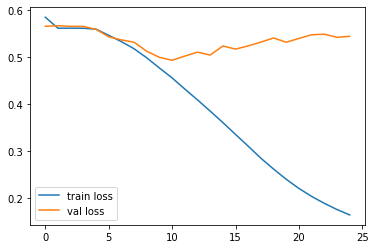

In [29]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

With larger training data

In [ ]:
model.fit(
  x=[train_user, train_item],
  y=train_ratings,
  epochs=10,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_ratings], test_ratings),
)

In [36]:
user_embd=model.layers[2].get_weights()[0]
item_embd=model.layers[3].get_weights()[0]

In [102]:
num_users=200
latent_factors=10

top_200_users_id=df_events.new_vis_id.value_counts().iloc[:num_users].index
top_200_users=user_embd[top_200_users_id,:]


mag_factors=np.apply_along_axis(
    lambda r: pow(np.sum(pow(r,2)),0.5),
    1,
    top_200_users
).reshape(-1,1)

top_200_users=np.concatenate([top_200_users,mag_factors],axis=1)

temp_1=top_200_users.reshape(num_users,1,latent_factors+1)
temp_2=top_200_users.reshape(1,num_users,latent_factors+1)


numerator=temp_1[...,:latent_factors]*temp_2[...,:latent_factors]
denominator=temp_1[...,latent_factors]*temp_2[...,latent_factors]


# (numerator/denominator)#.sum(axis=2)
df_cos=pd.DataFrame(numerator.sum(axis=2)/denominator
                    ,columns=['user_'+str(i) for i in top_200_users_id],
                    index=['user_'+str(i) for i in top_200_users_id])




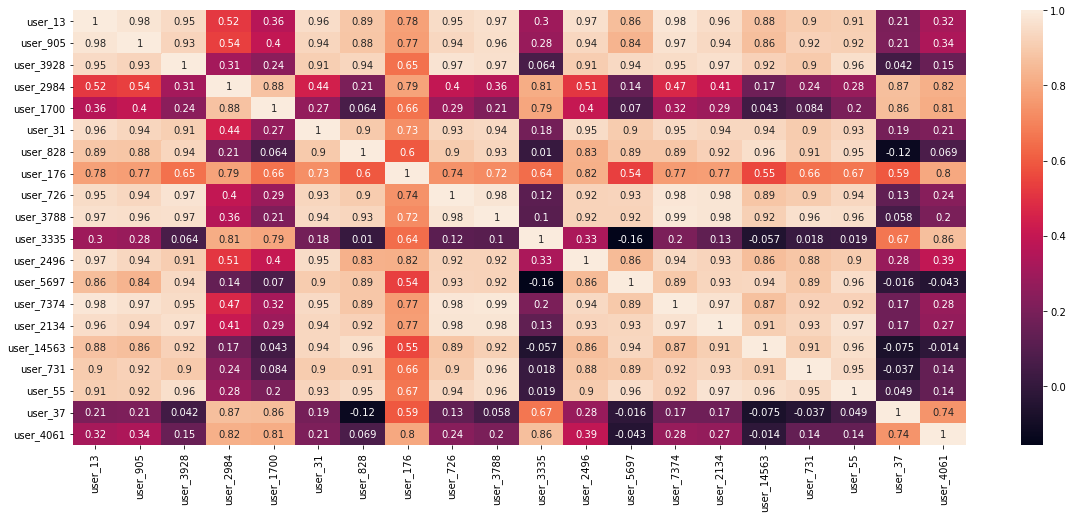

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
sns.heatmap(df_cos.iloc[:20,:20],annot=True)

# User-Item similarity

In [104]:
num_users=20
num_items=30
latent_factors=10

top_200_users_id=df_events.new_vis_id.value_counts().iloc[:num_users].index
top_200_users=user_embd[top_200_users_id,:]


mag_factors=np.apply_along_axis(
    lambda r: pow(np.sum(pow(r,2)),0.5),
    1,
    top_200_users
).reshape(-1,1)

top_200_users=np.concatenate([top_200_users,mag_factors],axis=1)

####################ITEMS####################################

top_items_id=df_events.new_item_id.value_counts().iloc[:num_items].index
top_items=user_embd[top_items_id,:]


mag_factors=np.apply_along_axis(
    lambda r: pow(np.sum(pow(r,2)),0.5),
    1,
    top_items
).reshape(-1,1)

top_items=np.concatenate([top_items,mag_factors],axis=1)


temp_1=top_200_users.reshape(num_users,1,latent_factors+1)
temp_2=top_items.reshape(1,num_items,latent_factors+1)


numerator=temp_1[...,:latent_factors]*temp_2[...,:latent_factors]
denominator=temp_1[...,latent_factors]*temp_2[...,latent_factors]


# (numerator/denominator)#.sum(axis=2)
df_cos_cross=pd.DataFrame(numerator.sum(axis=2)/denominator
                    ,columns=['item_'+str(i) for i in top_items_id],
                    index=['user_'+str(i) for i in top_200_users_id])




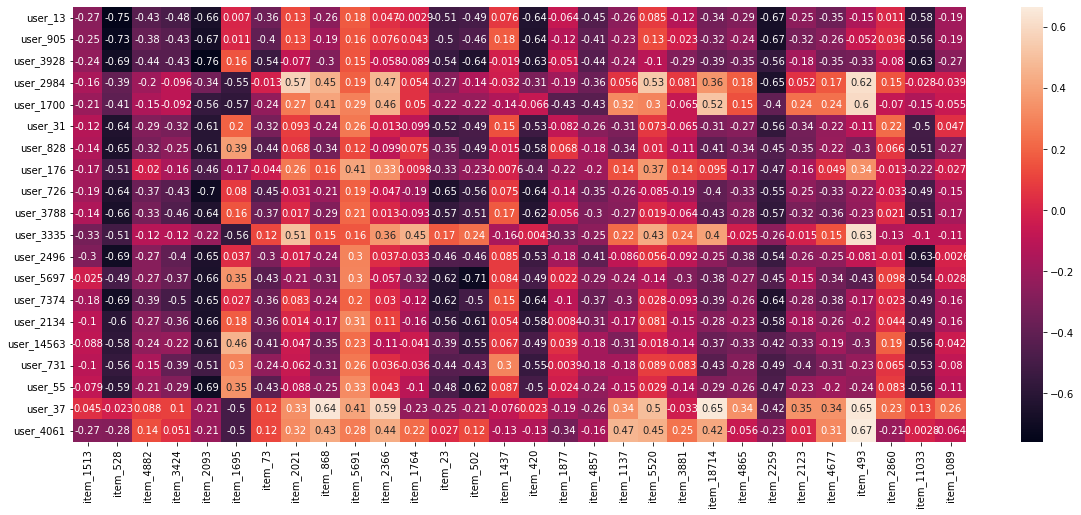

In [105]:
plt.figure(figsize=(20,8))
sns.heatmap(df_cos_cross,annot=True)

In [121]:
set(df_events[df_events.new_vis_id==905]['new_item_id'])-set(df_events[df_events.new_vis_id==37]['new_item_id'])

{75779,
 32771,
 34821,
 20484,
 28677,
 10249,
 55310,
 26641,
 4114,
 2067,
 22547,
 22,
 14360,
 28696,
 14361,
 20507,
 22557,
 26653,
 31,
 20510,
 12321,
 63523,
 94246,
 16423,
 44,
 18477,
 2093,
 26676,
 2100,
 4149,
 53305,
 12346,
 10300,
 2118,
 6217,
 73,
 2123,
 6219,
 12365,
 92238,
 76,
 32848,
 18511,
 34898,
 38998,
 43096,
 18521,
 4185,
 92248,
 16481,
 82019,
 26724,
 61541,
 14438,
 16489,
 12399,
 26740,
 24693,
 30836,
 69753,
 4220,
 26751,
 53391,
 145,
 18578,
 14482,
 49301,
 10392,
 45209,
 8348,
 28833,
 162,
 14499,
 34978,
 30885,
 75941,
 167,
 86187,
 8364,
 30891,
 180,
 2229,
 183,
 86203,
 193,
 4290,
 4294,
 199,
 2249,
 4299,
 2259,
 92374,
 216,
 6361,
 4316,
 24797,
 97737,
 69855,
 22755,
 6371,
 78055,
 92391,
 55530,
 18668,
 92399,
 92403,
 12532,
 28917,
 80116,
 30968,
 16635,
 92412,
 37117,
 92413,
 260,
 6404,
 33030,
 41223,
 8456,
 20745,
 26889,
 97745,
 97747,
 4367,
 97748,
 2324,
 55573,
 96536,
 18714,
 97750,
 97752,
 37161,
 88

In [74]:
temp=np.array([[100,500,300],
          [1,2,3]])


temp=np.concatenate([temp,temp.sum(axis=1).reshape(-1,1)],axis=1)

#cosine = element wise multiplication of latent factors/ magnitude of latent vectors computed about origin
#we can compute magntude as appended vector to top 200 users and then use it for division



o=temp.reshape(2,1,4)
t=temp.reshape(1,2,4)


numerator=o[...,:3]*t[...,:3]
denominator=o[...,3]*t[...,3]


# (numerator/denominator)#.sum(axis=2)
numerator.sum(axis=2)/denominator